In [3]:
#!/usr/bin/env python3
"""
Full PCA interpretability atlas for Mouse Neural Responses (VISpm subset).

For each PC:
 - Plotly bar chart (top ±10 scenes)
 - Matplotlib mosaic of top 10 and bottom 10 image thumbnails
 - Builds combined index.html for browsing all PCs
"""

import os, pickle, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import plotly.graph_objects as go

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = 'brain_area.npy'  # <-- one label per neuron
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
IMGS_PATH   = '/home/maria/MITNeuralComputation/vit_embeddings/images'
AREA_NAME   = 'VISpm'   # <-- change to VISam, VISp, etc.
top_k = 10
out_dir = f'mouse_pca_panels_{AREA_NAME}'
os.makedirs(out_dir, exist_ok=True)

# ---------------------------------------------------------------
# LOAD NEURAL DATA + AREA LABELS
# ---------------------------------------------------------------
print(f"🔹 Loading neural responses + filtering to {AREA_NAME} ...")
dat = np.load(NEURAL_PATH, mmap_mode='r')  # (neurons, 118*50*5900)
areas = np.load(AREAS_PATH, allow_pickle=True)                 # (neurons,)
assert len(areas) == dat.shape[0], "Area label count mismatch with neurons"

# Filter
mask = areas == AREA_NAME
dat = dat[mask]
n_neurons, n_total = dat.shape
print(f"Selected {n_neurons} neurons in {AREA_NAME}")

# ---------------------------------------------------------------
# AVERAGE RESPONSES (confirmed correct order)
# ---------------------------------------------------------------
n_images, n_trials = 118, 50
n_time = n_total // (n_images * n_trials)
dat = dat.reshape(n_neurons, n_images, n_trials, n_time)
X_mean = dat.mean(axis=(2, 3))  # (neurons × images)
print("Averaged responses:", X_mean.shape)

# ---------------------------------------------------------------
# LOAD ViT LABELS (for scene names)
# ---------------------------------------------------------------
print("🔹 Loading ViT labels ...")
try:
    from torchvision.models import vit_b_16, ViT_B_16_Weights
    class_names = ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]
except Exception:
    class_names = [f"class_{i}" for i in range(1000)]

with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']

top1_idx = np.argmax(vit_logits, axis=1)
scene_labels = [class_names[i] for i in top1_idx]
image_ids = [f"scene_{i:03d}" for i in range(n_images)]
print(f"Found {len(scene_labels)} scene labels.")

# ---------------------------------------------------------------
# PCA
# ---------------------------------------------------------------
print("🔹 Running PCA ...")
X_centered = X_mean - X_mean.mean(axis=0, keepdims=True)
pca_full = PCA(n_components=min(X_centered.shape), random_state=0)
pca_full.fit(X_centered)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find smallest number of PCs covering ≥90% variance
n_components = np.searchsorted(cumulative_var, 0.90) + 1
print(f"Selecting {n_components} PCs to cover 90% of variance "
      f"({100*cumulative_var[n_components-1]:.2f}%)")

# Refit PCA with that number of components
pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_centered)  # neuron projections
V = pca.components_.T              # image loadings
expl_var = pca.explained_variance_ratio_

# ---------------------------------------------------------------
# Plotly: bar chart (ViT-style)
# ---------------------------------------------------------------
def plot_pc_semantics_plotly(V, class_names, pc_idx, top_k=10):
    """ViT-style bar plot showing top ±K scenes for a given PC."""
    v_raw = V[:, pc_idx]
    v = v_raw - np.mean(v_raw)  # recenter for visualization only

    pos_idx = np.argsort(v)[-top_k:][::-1]
    neg_idx = np.argsort(v)[:top_k]
    pos_names = [class_names[i] for i in pos_idx]
    neg_names = [class_names[i] for i in neg_idx]

    pos_y = [name + " " for name in pos_names]
    neg_y = [name for name in neg_names]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=v[pos_idx], y=pos_y,
        orientation='h', marker_color='green', name='Positive'
    ))
    fig.add_trace(go.Bar(
        x=v[neg_idx], y=neg_y,
        orientation='h', marker_color='red', name='Negative'
    ))

    xmax = float(np.max(np.abs(v))) if v.size else 1.0
    fig.update_xaxes(range=[-xmax, xmax])
    fig.update_layout(
        title=f"{AREA_NAME} — PC{pc_idx+1} (top ±{top_k} scenes)",
        barmode='overlay',
        xaxis_title="Loading weight (centered for viz)",
        yaxis_title="Scene",
        template="plotly_white"
    )
    return fig

# ---------------------------------------------------------------
# Matplotlib: 10×2 image mosaic (top/bottom)
# ---------------------------------------------------------------
def save_top_images(V, pc_idx, image_ids, imgs_path, out_dir, top_n=10):
    """Save a mosaic of top/bottom scoring images for the given PC."""
    scores = V[:, pc_idx]
    top_idx = np.argsort(scores)[-top_n:][::-1]
    bot_idx = np.argsort(scores)[:top_n]

    fig, axes = plt.subplots(2, top_n, figsize=(2.5 * top_n, 5))

    for i, idx in enumerate(top_idx):
        img_name = f"{image_ids[idx]}.png"
        img_path = os.path.join(imgs_path, img_name)
        if os.path.exists(img_path):
            axes[0, i].imshow(Image.open(img_path), cmap='gray')
        axes[0, i].set_title(f"Top {i+1} ({scores[idx]:.2f})", fontsize=8)
        axes[0, i].axis("off")

    for i, idx in enumerate(bot_idx):
        img_name = f"{image_ids[idx]}.png"
        img_path = os.path.join(imgs_path, img_name)
        if os.path.exists(img_path):
            axes[1, i].imshow(Image.open(img_path), cmap='gray')
        axes[1, i].set_title(f"Bottom {i+1} ({scores[idx]:.2f})", fontsize=8)
        axes[1, i].axis("off")

    plt.suptitle(f"Example images for PC{pc_idx+1} ({AREA_NAME}, {expl_var[pc_idx]*100:.2f}% variance)",
                 fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"PC{pc_idx+1:02d}_images.png")
    plt.savefig(out_path, dpi=150)
    plt.close(fig)

# ---------------------------------------------------------------
# MAIN LOOP
# ---------------------------------------------------------------
for pc_idx in range(n_components):
    print(f"Saving PC{pc_idx+1}/{n_components} for {AREA_NAME} ...")

    fig = plot_pc_semantics_plotly(V, scene_labels, pc_idx, top_k=top_k)
    fig.write_html(os.path.join(out_dir, f"PC{pc_idx+1:02d}_bars.html"))

    save_top_images(V, pc_idx, image_ids, IMGS_PATH, out_dir, top_n=10)

print(f"\n✅ All {n_components} components saved in '{out_dir}/'")

# ---------------------------------------------------------------
# HTML INDEX BUILDER
# ---------------------------------------------------------------
print("🔹 Building index.html ...")
index_path = os.path.join(out_dir, "index.html")

bar_files = sorted([f for f in os.listdir(out_dir) if f.endswith("_bars.html")])
pcs = [f.split("_")[0] for f in bar_files]

html_parts = [
    "<html><head>",
    "<meta charset='utf-8'/>",
    f"<title>Mouse PCA Atlas — {AREA_NAME}</title>",
    "<style>",
    "body { font-family: sans-serif; background-color: #f9f9f9; margin: 40px; }",
    "h2 { margin-top: 60px; }",
    "iframe { border: none; width: 100%; height: 500px; }",
    "img { width: 100%; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.2); }",
    ".panel { background: white; padding: 20px; border-radius: 10px; margin-bottom: 40px; "
    "box-shadow: 0 0 10px rgba(0,0,0,0.05); }",
    "a { text-decoration: none; color: #3366cc; }",
    "</style></head><body>",
    f"<h1>{AREA_NAME} — Mouse Brain PCA Interpretability Atlas</h1>",
    f"<p>Found {len(pcs)} components for {AREA_NAME} in <code>{out_dir}</code>.</p>",
    "<h3>Jump to component:</h3><ul>",
]

for pc_prefix in pcs:
    num = pc_prefix.replace("PC", "")
    html_parts.append(f"<li><a href='#{pc_prefix}'>PC{int(num)}</a></li>")
html_parts.append("</ul>")

for pc_prefix in pcs:
    num = pc_prefix.replace("PC", "")
    bar_html = f"{pc_prefix}_bars.html"
    img_png = f"{pc_prefix}_images.png"

    html_parts.append(f"<div class='panel' id='{pc_prefix}'>")
    html_parts.append(f"<h2>{AREA_NAME} — Principal Component {int(num)}</h2>")
    if os.path.exists(os.path.join(out_dir, bar_html)):
        html_parts.append(f"<iframe src='{bar_html}'></iframe>")
    if os.path.exists(os.path.join(out_dir, img_png)):
        html_parts.append(f"<img src='{img_png}' alt='PC{num} images'/>")
    html_parts.append("</div>")

html_parts.append("</body></html>")

with open(index_path, "w") as f:
    f.write("\n".join(html_parts))

print(f"✅ HTML index created: {index_path}")


🔹 Loading neural responses + filtering to VISpm ...
Selected 4771 neurons in VISpm
Averaged responses: (4771, 118)
🔹 Loading ViT labels ...
Found 118 scene labels.
🔹 Running PCA ...
Selecting 69 PCs to cover 90% of variance (90.16%)
Saving PC1/69 for VISpm ...
Saving PC2/69 for VISpm ...
Saving PC3/69 for VISpm ...
Saving PC4/69 for VISpm ...
Saving PC5/69 for VISpm ...
Saving PC6/69 for VISpm ...
Saving PC7/69 for VISpm ...
Saving PC8/69 for VISpm ...
Saving PC9/69 for VISpm ...
Saving PC10/69 for VISpm ...
Saving PC11/69 for VISpm ...
Saving PC12/69 for VISpm ...
Saving PC13/69 for VISpm ...
Saving PC14/69 for VISpm ...
Saving PC15/69 for VISpm ...
Saving PC16/69 for VISpm ...
Saving PC17/69 for VISpm ...
Saving PC18/69 for VISpm ...
Saving PC19/69 for VISpm ...
Saving PC20/69 for VISpm ...
Saving PC21/69 for VISpm ...
Saving PC22/69 for VISpm ...
Saving PC23/69 for VISpm ...
Saving PC24/69 for VISpm ...
Saving PC25/69 for VISpm ...
Saving PC26/69 for VISpm ...
Saving PC27/69 for VIS

🔹 Loading ViT embeddings ...
ViT embeddings: (118, 10) (images × PCs)
🔹 Loading neural data (VISpm) ...
Neural loadings shape: (118, 10) (images × PCs)
Pearson correlation: r = 0.436, p = 7.867e-07
Permutation test (|r|>=observed): p_perm = 0.000


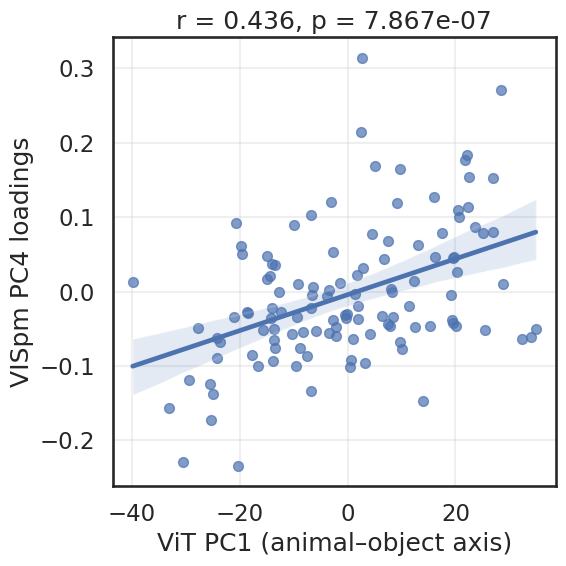

In [4]:
#!/usr/bin/env python3
"""
Correlate ViT PC1 (animal–object axis) with VISpm PC4 loadings.
"""

import numpy as np
import pickle
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from skbio.stats.composition import clr

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
VIT_PATH = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH = 'brain_area.npy'
AREA_NAME = 'VISpm'
n_images, n_trials = 118, 50
np.random.seed(0)

# ---------------------------------------------------------------
# LOAD ViT EMBEDDINGS AND RUN PCA
# ---------------------------------------------------------------
print("🔹 Loading ViT embeddings ...")
with open(VIT_PATH, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']
X = softmax(vit_arr, axis=1)
X_clr = clr(X + 1e-12)

pca_vit = PCA(n_components=10, random_state=0)
U_vit = pca_vit.fit_transform(X_clr)
print(f"ViT embeddings: {U_vit.shape} (images × PCs)")

# ---------------------------------------------------------------
# LOAD NEURAL DATA AND FILTER TO VISpm
# ---------------------------------------------------------------
print(f"🔹 Loading neural data ({AREA_NAME}) ...")
dat = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)
mask = areas == AREA_NAME
dat = dat[mask]
n_neurons, n_total = dat.shape
n_time = n_total // (n_images * n_trials)
dat = dat.reshape(n_neurons, n_images, n_trials, n_time)
X_mean = dat.mean(axis=(2, 3))  # (neurons × images)

# Run PCA
pca_neuro = PCA(n_components=10, random_state=0)
U_neuro = pca_neuro.fit_transform(X_mean - X_mean.mean(axis=0))
V_neuro = pca_neuro.components_.T
print(f"Neural loadings shape: {V_neuro.shape} (images × PCs)")

# ---------------------------------------------------------------
# EXTRACT THE TWO PC VECTORS TO COMPARE
# ---------------------------------------------------------------
vit_pc1 = U_vit[:, 0]
vispm_pc4 = V_neuro[:, 3]   # PC4 (index 3 if 0-based)

# ---------------------------------------------------------------
# CORRELATION AND PERMUTATION TEST
# ---------------------------------------------------------------
r, p = pearsonr(vit_pc1, vispm_pc4)
print(f"Pearson correlation: r = {r:.3f}, p = {p:.3e}")

# Permutation test
n_perm = 1000
perm_r = np.zeros(n_perm)
for i in range(n_perm):
    perm_r[i] = np.corrcoef(vit_pc1, np.random.permutation(vispm_pc4))[0, 1]

p_perm = np.mean(np.abs(perm_r) >= abs(r))
print(f"Permutation test (|r|>=observed): p_perm = {p_perm:.3f}")

# ---------------------------------------------------------------
# PLOT
# ---------------------------------------------------------------
sns.set(style="white", context="talk")
plt.figure(figsize=(6, 6))
sns.regplot(x=vit_pc1, y=vispm_pc4, scatter_kws=dict(alpha=0.7, s=50))
plt.xlabel("ViT PC1 (animal–object axis)")
plt.ylabel("VISpm PC4 loadings")
plt.title(f"r = {r:.3f}, p = {p:.3e}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("vit_vispm_correlation.png", dpi=200)
plt.show()


🔹 ViT embeddings ...
ViT PCs shape: (118, 10)
🔹 Neural data (VISpm) ...
VISpm PCs shape: (118, 10)

Top correlations:
  ViT PC1 ↔ VISpm PC4: r=0.436, p=7.867e-07
  ViT PC2 ↔ VISpm PC1: r=-0.353, p=8.865e-05
  ViT PC9 ↔ VISpm PC6: r=0.290, p=1.471e-03
  ViT PC4 ↔ VISpm PC2: r=0.271, p=3.045e-03
  ViT PC4 ↔ VISpm PC8: r=0.239, p=9.047e-03


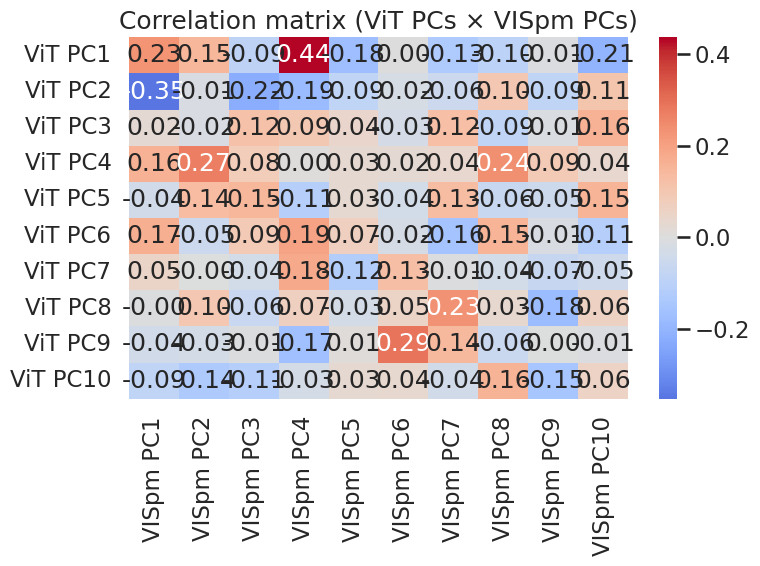

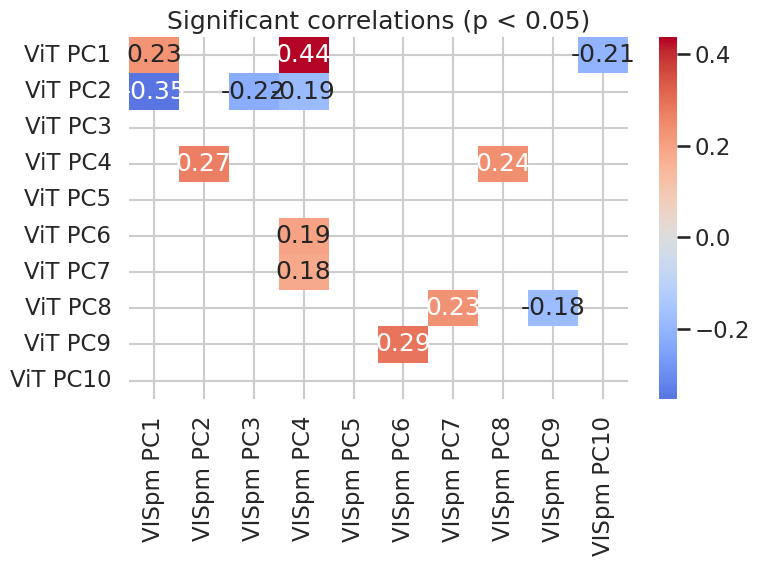

In [5]:
#!/usr/bin/env python3
"""
Compute correlation heatmap between ViT PCs and VISpm PCs.
Each cell = Pearson r between per-image loadings of one ViT PC and one VISpm PC.
"""

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.special import softmax
from skbio.stats.composition import clr

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
VIT_PATH   = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = 'brain_area.npy'
AREA_NAME   = 'VISpm'
n_images, n_trials = 118, 50
N_PCS = 10
N_PERM = 1000
np.random.seed(0)

# ---------------------------------------------------------------
# LOAD AND RUN PCA — ViT
# ---------------------------------------------------------------
print("🔹 ViT embeddings ...")
with open(VIT_PATH, 'rb') as f:
    vit_raw = pickle.load(f)['natural_scenes']

X = softmax(vit_raw, axis=1)
X_clr = clr(X + 1e-12)
pca_vit = PCA(n_components=N_PCS, random_state=0)
U_vit = pca_vit.fit_transform(X_clr)
print("ViT PCs shape:", U_vit.shape)

# ---------------------------------------------------------------
# LOAD AND RUN PCA — VISpm
# ---------------------------------------------------------------
print(f"🔹 Neural data ({AREA_NAME}) ...")
dat = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)
mask = areas == AREA_NAME
dat = dat[mask]
n_neurons, n_total = dat.shape
n_time = n_total // (n_images * n_trials)
dat = dat.reshape(n_neurons, n_images, n_trials, n_time)
X_mean = dat.mean(axis=(2, 3))

pca_neuro = PCA(n_components=N_PCS, random_state=0)
V_neuro = pca_neuro.fit(X_mean - X_mean.mean(axis=0)).components_.T
print("VISpm PCs shape:", V_neuro.shape)

# ---------------------------------------------------------------
# CORRELATION MATRIX
# ---------------------------------------------------------------
R = np.zeros((N_PCS, N_PCS))
P = np.zeros((N_PCS, N_PCS))

for i in range(N_PCS):
    for j in range(N_PCS):
        r, p = pearsonr(U_vit[:, i], V_neuro[:, j])
        R[i, j] = r
        P[i, j] = p

print("\nTop correlations:")
flat_idx = np.argsort(np.abs(R), axis=None)[::-1][:5]
for idx in flat_idx:
    i, j = np.unravel_index(idx, R.shape)
    print(f"  ViT PC{i+1} ↔ VISpm PC{j+1}: r={R[i,j]:.3f}, p={P[i,j]:.3e}")

# ---------------------------------------------------------------
# SIGNIFICANCE MASK
# ---------------------------------------------------------------
mask_sig = (P < 0.05)
R_masked = np.where(mask_sig, R, np.nan)

# ---------------------------------------------------------------
# PLOT HEATMAPS
# ---------------------------------------------------------------
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8,6))
sns.heatmap(R, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            xticklabels=[f"VISpm PC{j+1}" for j in range(N_PCS)],
            yticklabels=[f"ViT PC{i+1}" for i in range(N_PCS)])
plt.title("Correlation matrix (ViT PCs × VISpm PCs)")
plt.tight_layout()
plt.savefig("vit_vispm_pc_heatmap_all.png", dpi=200)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(R_masked, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            xticklabels=[f"VISpm PC{j+1}" for j in range(N_PCS)],
            yticklabels=[f"ViT PC{i+1}" for i in range(N_PCS)])
plt.title("Significant correlations (p < 0.05)")
plt.tight_layout()
plt.savefig("vit_vispm_pc_heatmap_sig.png", dpi=200)
plt.show()
